In [1]:
import os
import numpy as np
import scipy.stats
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import re
from IPython.display import HTML

mpl.rcParams['figure.dpi'] = 300

In [2]:
def read_sf_txt(path, samples=None, times=None):
    files = os.listdir(path)
    reg = re.compile(r'^S2_\d+_time_\d+.txt$')
    sf_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in sf_files]))))
    if times is None:
        times = list(set(list(sorted([int(f[:-4].split('_')[3]) for f in sf_files]))))
    sfs = []
    for t in times:
        sf = []
        for s in samples:
            with open(os.path.join(path, f'S2_{s}_time_{t}.txt'), 'r') as f:
                sf.append([float(v) for v in f.read().split()])
        sfs.append(np.array(sf))
    return sfs

def read_sf_nc(path, samples=None, times=None):
    raise NotImplementedError;

def sf_mean(sfs):
    means = [np.mean(sf, 0) for sf in sfs]
    return means

def sf_variance(sfs):
    variances = [np.var(sf, 0) for sf in sfs]
    return variances

def sf_quantiles(sfs, q):
    quantiles = [np.quantile(sf, q, 0) for sf in sfs]
    return quantiles

In [3]:
def _fit_sf(sfs, N):
    N0 = int(N**0.5)
    N1 = int(N**0.75)
    r = np.array([j/N for j in range(sfs.shape[1])])
    p = np.polyfit(np.log(r[N0:N1]), np.log(sfs[:,N0:N1].T), 1)
    return p

def plot_sf(paths, Ns, time, save_name=None, samples=None, read_func=read_sf_txt):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        sfs = read_func(path, samples, times=[time])
        mean = sf_mean(sfs)[0]
        r = np.array([j/N for j in range(len(mean))])
        plt.loglog(r[1:], mean[1:], color=f'C{i}', label=f'N={N}')
        ps = _fit_sf(sfs[0], N)
        p0_mean = ps[0].mean()
        p0_stdev = ps[0].std() / np.sqrt(sfs[0].shape[0])
        p1_mean = ps[1].mean()
        p1_stdev = ps[1].std() / np.sqrt(sfs[0].shape[0])
        plt.loglog(r[1:], np.exp(p1_mean)*r[1:]**p0_mean, '--', color=f'C{i}', label=f'$r^{{{p0_mean:.2f} \\pm {p0_stdev:.3f}}}$', alpha=0.5)
    plt.xlabel('$r$')
    plt.ylabel(r'$S_2(r)$')
    plt.legend()
    plt.title(f'Structure Function $S_2$')
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    
def animate_sf(paths, Ns, times=None, samples=None, read_func=read_sf_txt):
    sfs = [read_func(path, samples, times) for path in paths]
    means = [sf_mean(sf) for sf in sfs]
    max_mean = max([max([max([max(t[1:]) for t in m]) for m in means]) for mean in means])
    min_mean = min([min([min([min(t[1:]) for t in m]) for m in means]) for mean in means])
    r = [[j/N for j in range(len(mean[0]))] for mean,N in zip(means,Ns)]
    fig, ax = plt.subplots()
    lines = []
    for N in Ns:
        lines.append(plt.loglog([], label=f'N={N}')[0])
    ax.set_xlim(r[-1][1], 0.5)
    ax.set_ylim(min_mean, max_mean)
    plt.legend()
    def animate(frame):
        for i,line in enumerate(lines):
            line.set_data((r[i][1:], means[i][frame][1:]))
        return lines
    anim = FuncAnimation(fig, animate, frames=len(means[0]), interval=20)
    HTML(anim.to_html5_video())

# Structure Functions of Brownian Bridges

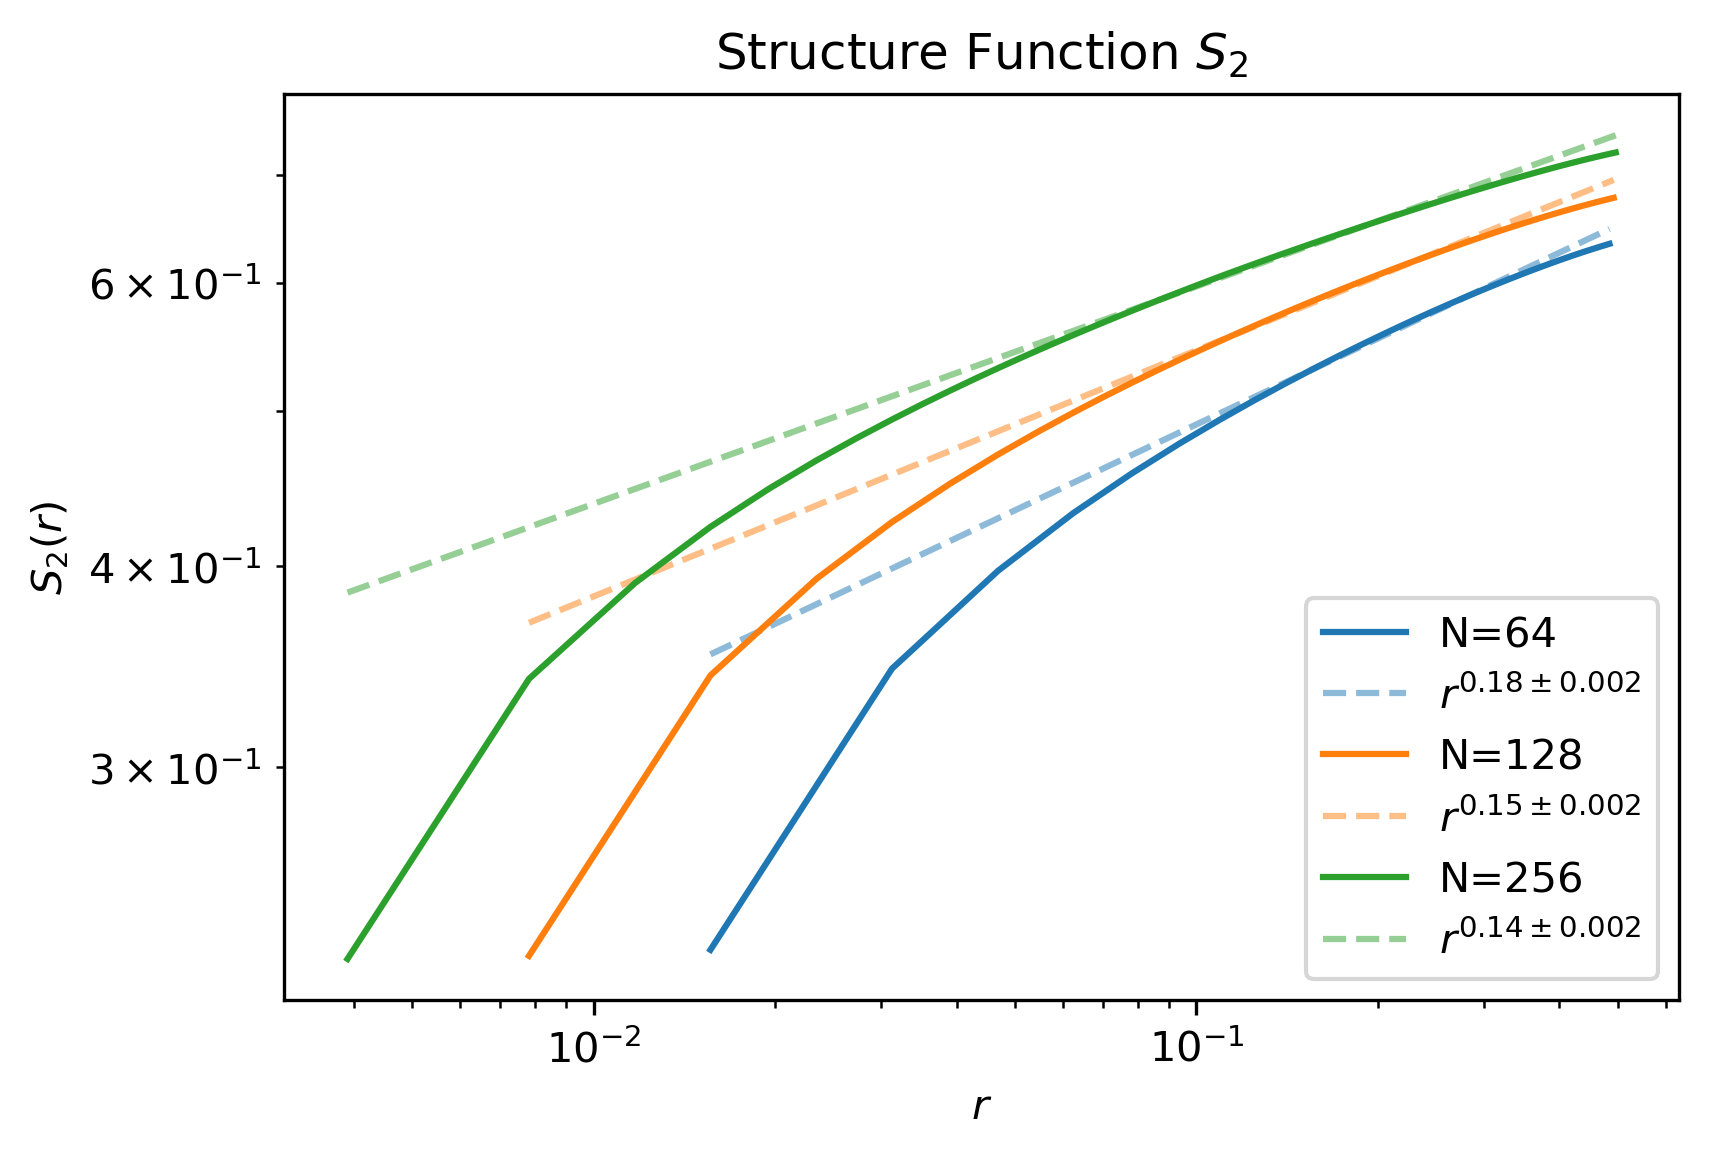

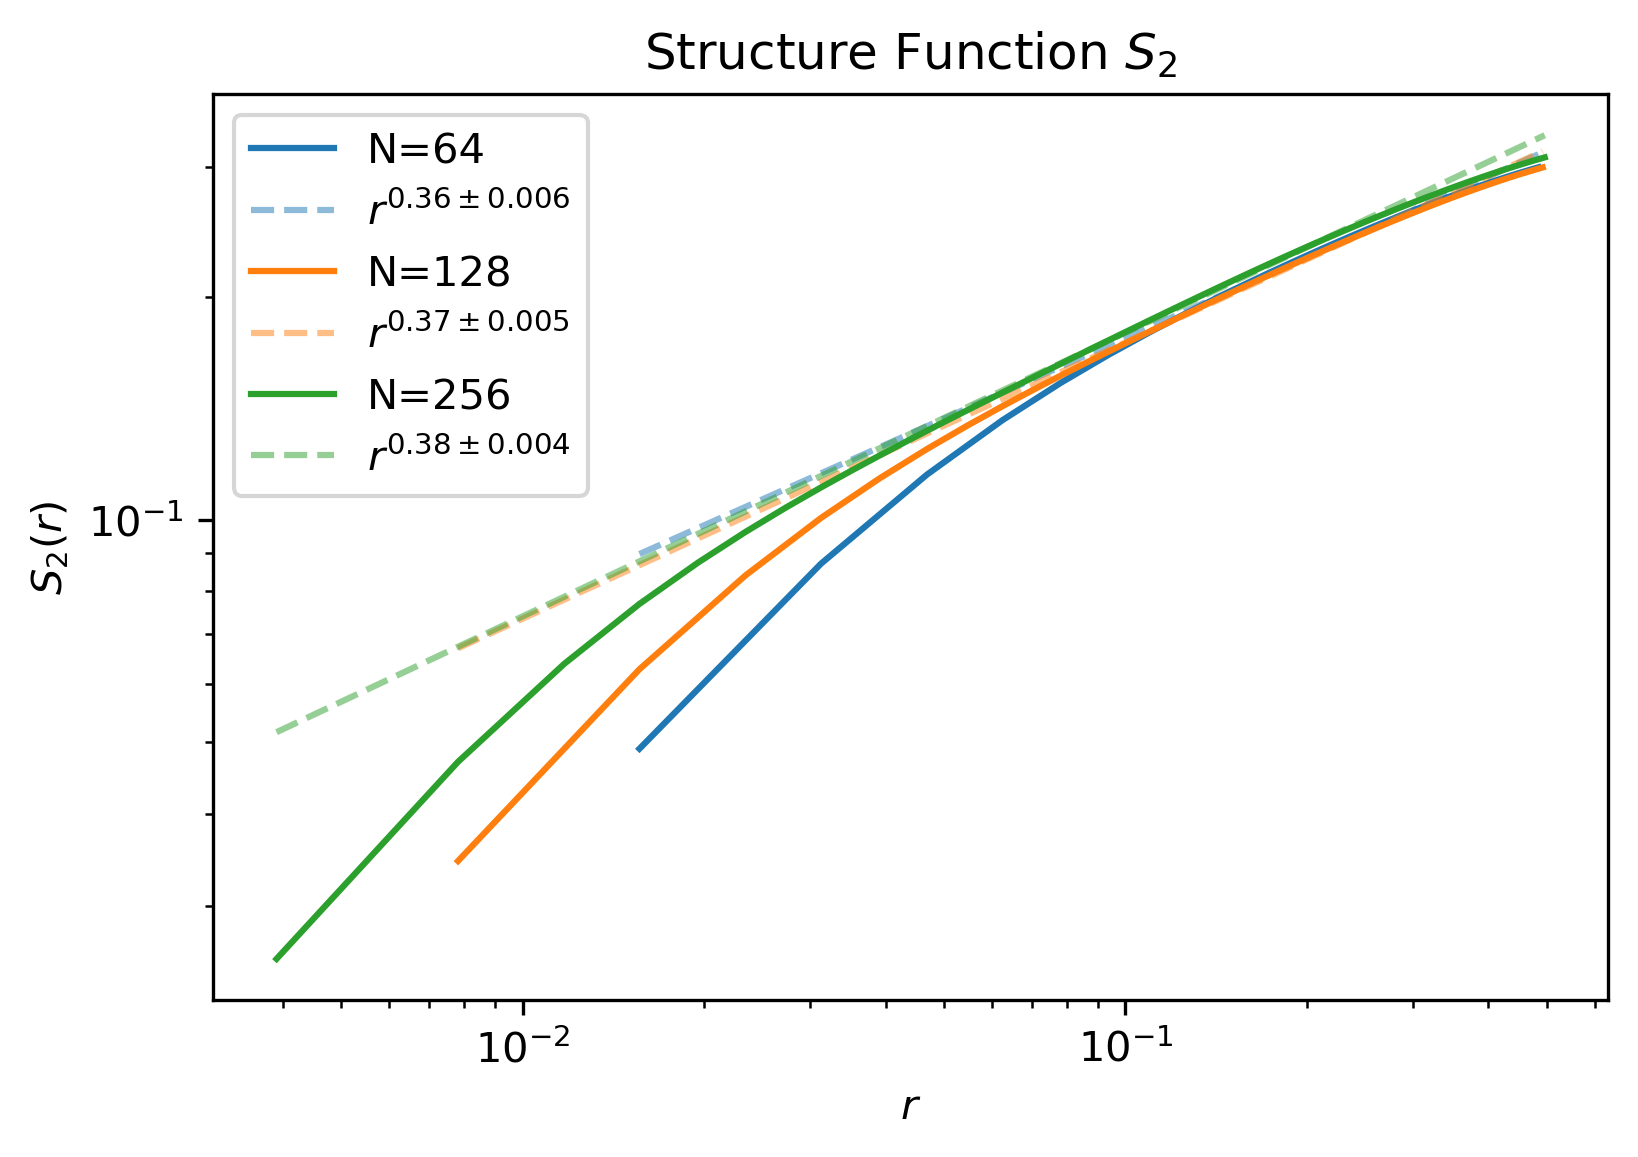

In [4]:
plot_sf(['/home/tobias/Programmieren/azeban/build/bm_N64',
         '/home/tobias/Programmieren/azeban/build/bm_N128',
         '/home/tobias/Programmieren/azeban/build/bm_N256'],
        [64, 128, 256], 0,
        save_name='/home/tobias/Programmieren/azeban/build/bm_S2_t0.png')
plot_sf(['/home/tobias/Programmieren/azeban/build/bm_N64',
         '/home/tobias/Programmieren/azeban/build/bm_N128',
         '/home/tobias/Programmieren/azeban/build/bm_N256'],
        [64, 128, 256], 2,
        save_name='/home/tobias/Programmieren/azeban/build/bm_S2_t2.png')

# Structure Functions of Taylor Green

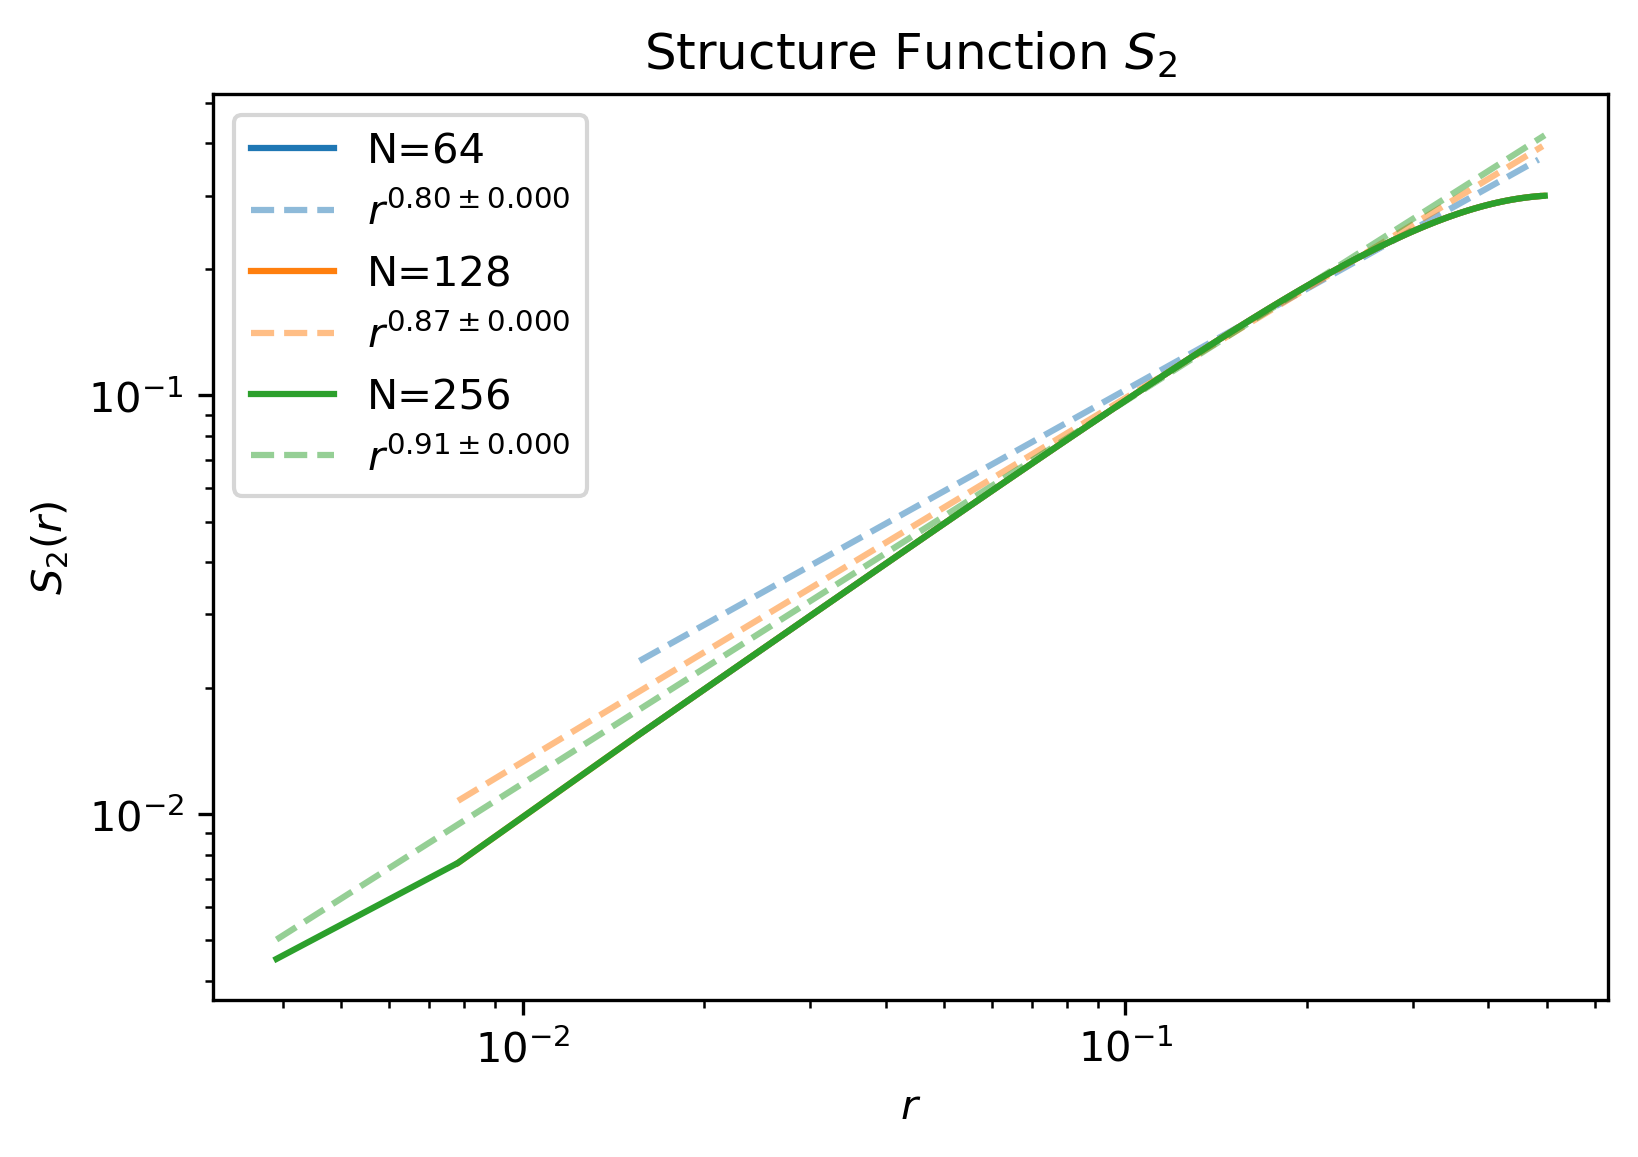

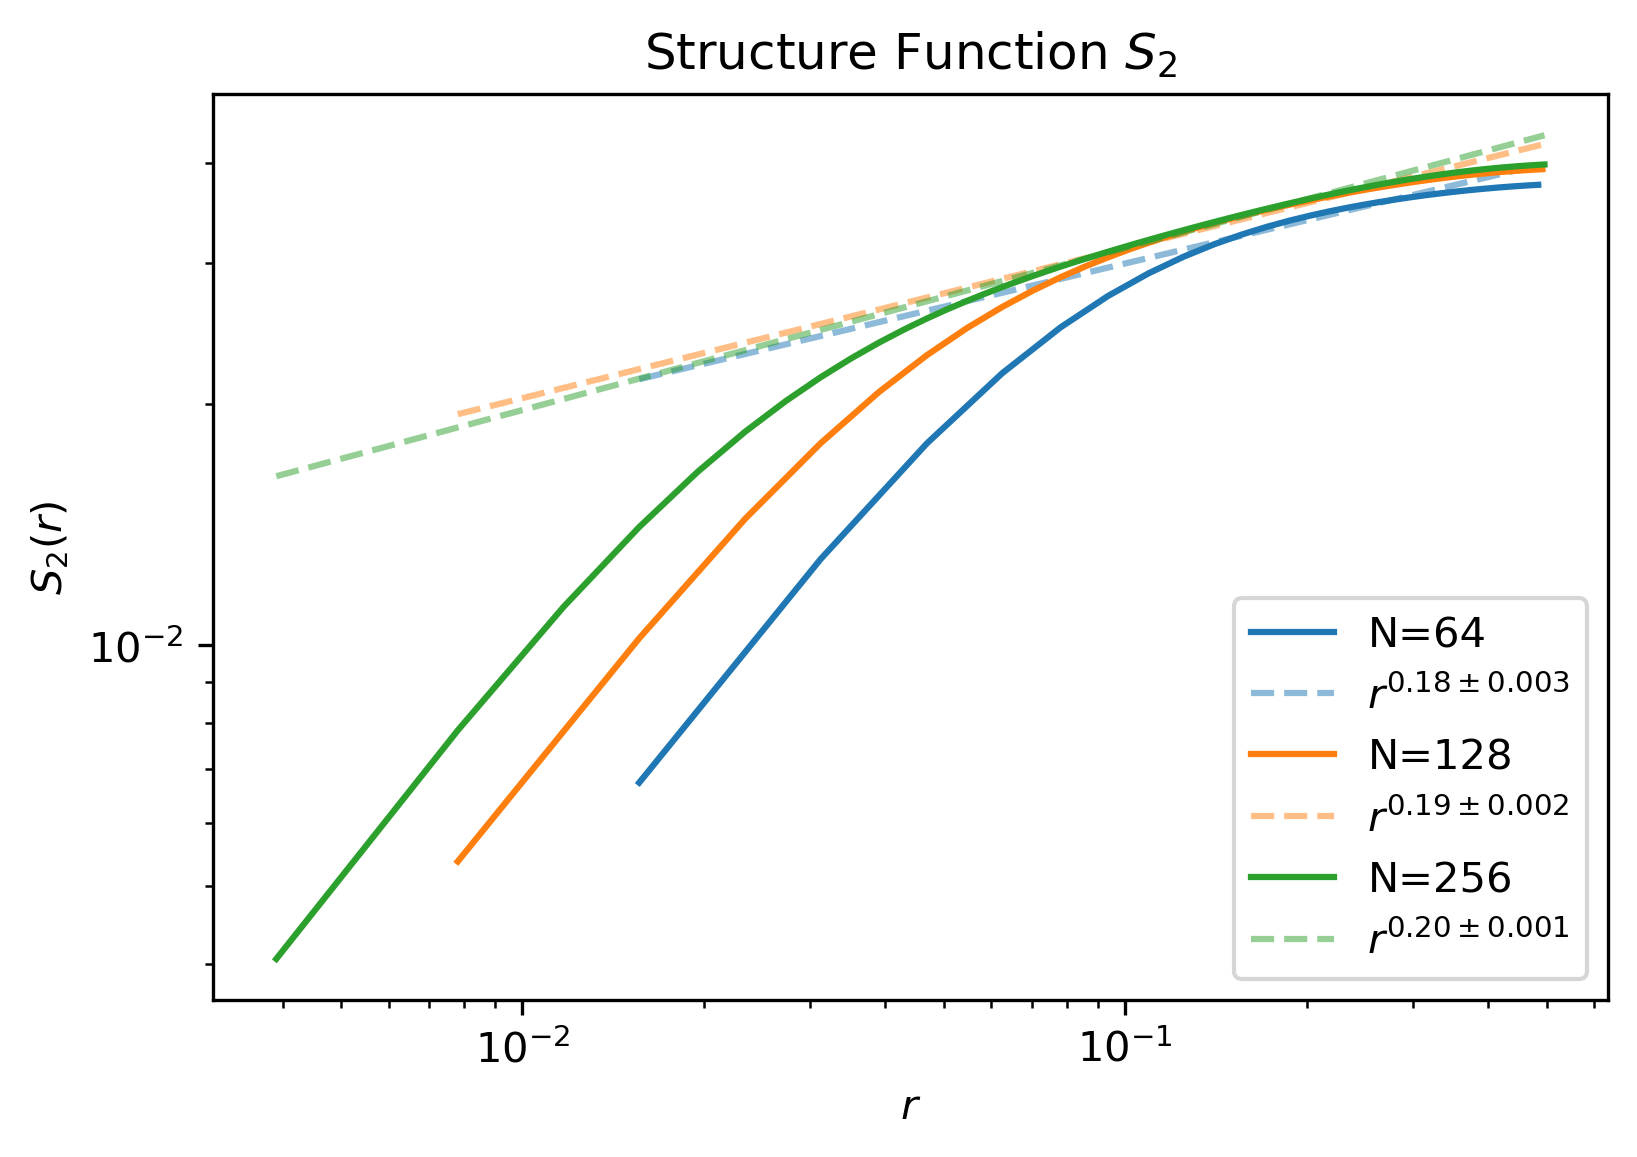

In [5]:
plot_sf(['/home/tobias/Programmieren/azeban/build/tg_N64',
         '/home/tobias/Programmieren/azeban/build/tg_N128',
         '/home/tobias/Programmieren/azeban/build/tg_N256'],
        [64, 128, 256], 0,
        save_name='/home/tobias/Programmieren/azeban/build/tg_S2_t0.png')
plot_sf(['/home/tobias/Programmieren/azeban/build/tg_N64',
         '/home/tobias/Programmieren/azeban/build/tg_N128',
         '/home/tobias/Programmieren/azeban/build/tg_N256'],
        [64, 128, 256], 10,
        save_name='/home/tobias/Programmieren/azeban/build/tg_S2_t10.png')